<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [126]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from sklearn.neighbors import NearestNeighbors

import gower

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [127]:
data = pd.read_csv('./data/datos_clientes.csv', index_col='Id_Cliente')

data.head()

,Genero,Edad,Ingreso,Puntaje_Gasto
Id_Cliente,,,,
1,Mujer,41,98115.05,39
2,Mujer,20,35458.14,75
3,Mujer,68,59872.08,55
4,Hombre,63,48508.93,51
5,Mujer,31,44431.11,54


In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Genero         200 non-null    object 
 1   Edad           200 non-null    int64  
 2   Ingreso        200 non-null    float64
 3   Puntaje_Gasto  200 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 7.8+ KB


Se importaron las librerías necesarias para el taller y se realizó la lectura de los datos del archivo csv `datos_clientes.csv`

Se observa que, en efecto, se tienen 200 filas, sin datos nulos y con las cuatro variables descritas al inicio: `Genero`, `Edad`, `Ingreso` y `Puntaje_Gasto`

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

**Estadísticas descriptivas**

En un primer análisis se describen las estadísticas para cada una de las variables cuantitativas. 

- El promedio de edad es de 38 años, con un máximo de 70 años y un mínimo de 18 años. Esto puede ser política del sistema, solo permitir que mayores de edad queden registrados
- El promedio de ingresos es del 60.624, teniendo el 75% de las personas por debajo de 77.143. Lo que nos puede indicar que en su mayoría se encuentran debajo de este valor. Se tiene un máximo de 138.584
- El puntaje gasto parece que va de 1 a 100, siendo el puntaje más alto de 99 para este dataset. En promedio las personas tienen un puntaje de 50 llegando en su mayoría hasta los 73 puntos.

In [129]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Edad,200.0,38.8500,13.969007,18.00,28.7500,36.00,49.000,70.00
Ingreso,200.0,60624.4466,26262.903416,13458.02,41512.7875,60777.96,77143.865,138584.52
Puntaje_Gasto,200.0,50.2000,25.823522,1.00,34.7500,50.00,73.000,99.00


Con el ánimo de conocer si estas estadísticas difieren según el género, se calcularon las estadísticas de ingreso y puntaje gasto por género. 

Se observa que hay más mujeres que hombres en el dataset (88 hombres y 112 mujeres), pero no se observan diferencias significativas en las estadísticas de `Ingreso` y `Puntaje_Gasto`. Se observa que **el nivel de Ingreso es ligeramente mayor en promedio para los hombres**, y que **el puntaje de gastos es ligeramente mayor en las mujeres**. 

In [130]:
data.groupby('Genero')[['Ingreso', 'Puntaje_Gasto']].describe()

Ingreso                                                               \
         count          mean           std       min         25%        50%   
Genero                                                                        
Hombre    88.0  62126.660455  26765.492953  13458.02  45003.0800  61706.565   
Mujer    112.0  59444.135714  25920.459216  15766.84  40013.4125  59355.305   

                              Puntaje_Gasto                                  \
               75%        max         count       mean       std  min   25%   
Genero                                                                        
Hombre  77731.3025  138584.52          88.0  48.511364  27.89677  1.0  24.5   
Mujer   76788.3875  126685.78         112.0  51.526786  24.11495  5.0  35.0   

                          
         50%   75%   max  
Genero                    
Hombre  50.0  70.0  97.0  
Mujer   50.0  73.0  99.0

Se decidió generar estadísticas agrupando las edades en seis grupos: 18-24, 25-34, 35-44, 45-54, 55-64 y mayores de 65. 

De igual manera se dividieron los géneros. 

- Se observa que para los hombres el nivel de ingresos aumenta de 25-44 años, y de la misma forma aumenta su puntaje de gasto. 
- Por otro lado, las mujeres tienen ese mismo comportamiento de nivel de ingresos, pero su puntaje de gasto aumenta de 18-34 años. Mostrando así que empiezan a gastar a una edad más temprana.

In [131]:
bins = [18, 24, 34, 44, 54, 64, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
data['Grupo_Etario'] = pd.cut(data['Edad'], bins=bins, labels=labels)

# Resumen por género y grupo etario
data.groupby(['Genero', 'Grupo_Etario'])[['Ingreso', 'Puntaje_Gasto']].describe()

Ingreso                                                    \
                      count          mean           std       min         25%   
Genero Grupo_Etario                                                             
Hombre 18-24           13.0  46628.876154  23406.995166  13458.02  20989.6400   
       25-34           22.0  78927.434545  32734.446993  22531.85  61793.4150   
       35-44           18.0  67001.986111  22499.533107  18797.16  58063.7100   
       45-54           14.0  58029.127143  20522.769162  24993.78  43724.2375   
       55-64            9.0  55780.227778  25094.510046  18434.74  42262.0400   
       65+              9.0  51366.806667  14577.260971  18437.21  45222.0600   
Mujer  18-24           18.0  41380.962222  19665.459732  15766.84  21775.7375   
       25-34           32.0  65815.380000  23049.652497  19003.52  46428.2325   
       35-44           24.0  66923.430000  31556.048353  19281.75  37553.3550   
       45-54           25.0  59210.614800  26541.550152  24402.32  41739.8400   
       55-64            7.0  57098.777143  20204.546850  19617.67  49946.0550   
       65+              5.0  51517.958000   9902.628197  37926.15  46970.5400   

                                                      Puntaje_Gasto  \
                           50%         75%        max         count   
Genero Grupo_Etario                                                   
Hombre 18-24         46455.340  61886.7100   80360.65          13.0   
       25-34         77390.985  96065.5225  138584.52          22.0   
       35-44         71638.860  83590.7100   91426.18          18.0   
       45-54         60761.560  69593.5850   97525.80          14.0   
       55-64         54475.760  71651.0800   94049.49           9.0   
       65+           52200.840  61969.1500   64156.37           9.0   
Mujer  18-24         37028.710  60292.7075   71427.64          18.0   
       25-34         72515.755  78621.0625  103654.79          32.0   
       35-44         72184.815  89797.3150  119534.68          24.0   
       45-54         54827.740  67219.4800  126685.78          25.0   
       55-64         58838.530  70389.0600   80565.01           7.0   
       65+           50529.760  59872.0800   62291.26           5.0   

                                                                           
                          mean        std   min    25%   50%    75%   max  
Genero Grupo_Etario                                                        
Hombre 18-24         49.076923  28.444278   5.0  39.00  52.0  66.00  92.0  
       25-34         62.454545  28.468407   1.0  55.25  71.0  80.25  97.0  
       35-44         50.777778  33.502512   1.0  17.75  51.5  84.75  95.0  
       45-54         34.357143  15.775381   4.0  26.75  38.5  46.00  56.0  
       55-64         28.444444  23.173860   3.0  11.00  15.0  51.00  60.0  
       65+           46.000000  13.453624  14.0  43.00  48.0  55.00  59.0  
Mujer  18-24         60.611111  22.186745   6.0  50.50  61.0  76.75  94.0  
       25-34         63.656250  21.413908  22.0  45.75  70.0  83.75  95.0  
       35-44         48.416667  29.120315   6.0  26.75  40.0  75.25  99.0  
       45-54         37.280000  16.754402   5.0  24.00  43.0  50.00  59.0  
       55-64         37.285714  20.385569   5.0  25.00  43.0  52.50  58.0  
       65+           48.000000   7.713624  35.0  48.00  50.0  52.00  55.0

**Visualizaciones**

- Revisando las distribuciones de Ingresos y de Puntaje Gasto por género, se puede concluir que no parece que exista un grupo predominante de género en cierto nivel de Ingresos o Puntaje de Gasto.
- Existe una distribución aproximadamente normal. Esto puede ayudarnos a la hora de hacer pruebas de hipótesis. 
- Se observa una poca cantidad de hombres con Puntaje de gasto entre 20 y 30. Pero de resto se observa que se distribuyen casi que equitativamente entre los dos géneros para los distintos puntajes

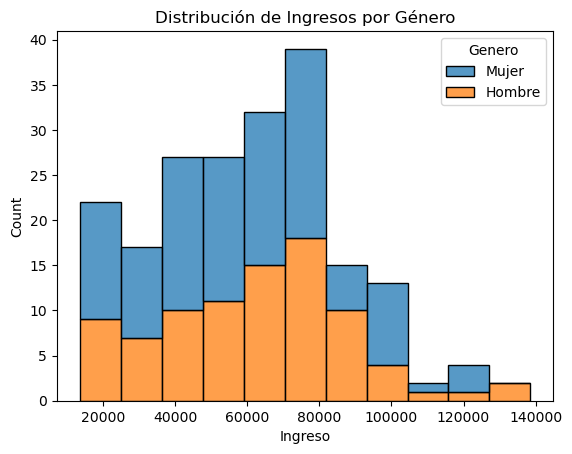

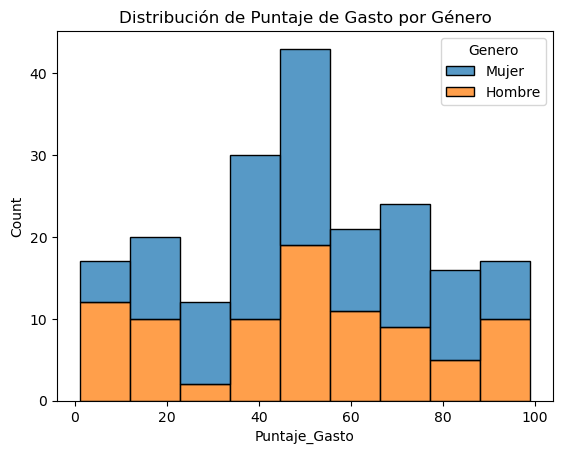

In [132]:
# Histograma de ingresos
sns.histplot(data=data, x='Ingreso', hue='Genero', multiple='stack')
plt.title('Distribución de Ingresos por Género')
plt.show()

# Histograma de puntaje de gasto
sns.histplot(data=data, x='Puntaje_Gasto', hue='Genero', multiple='stack')
plt.title('Distribución de Puntaje de Gasto por Género')
plt.show()

**Diagramas de caja**

- Se observan algunos datos atípicos por encima para el nivel de ingresos para mujeres entre los 45-54 años. De resto, parece que los datos se encuentran concentrados.
- El puntaje de gasto tiene valores atípicos por debajo para hombres entre los 25-34 años. Y para ambos géneros cuando son mayores a 65 años 

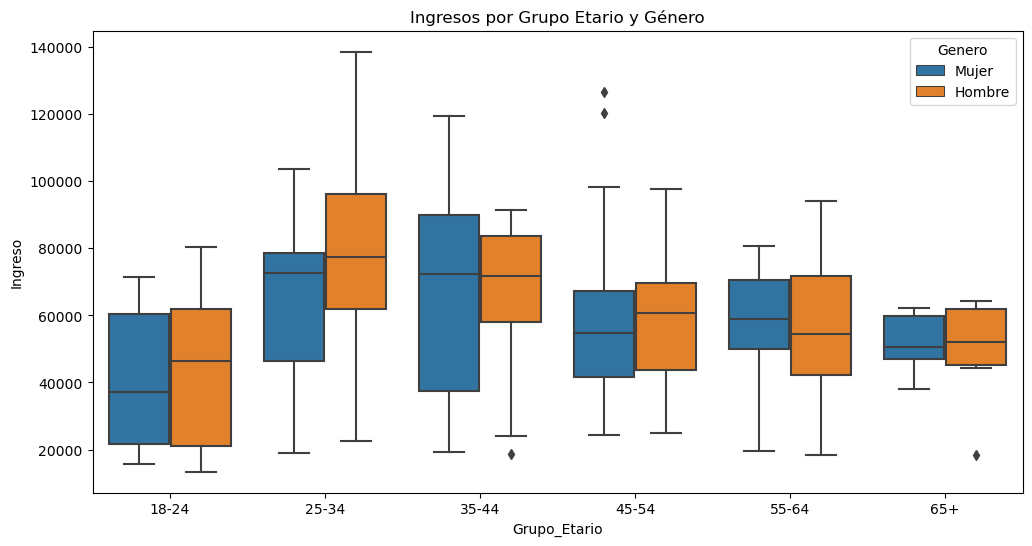

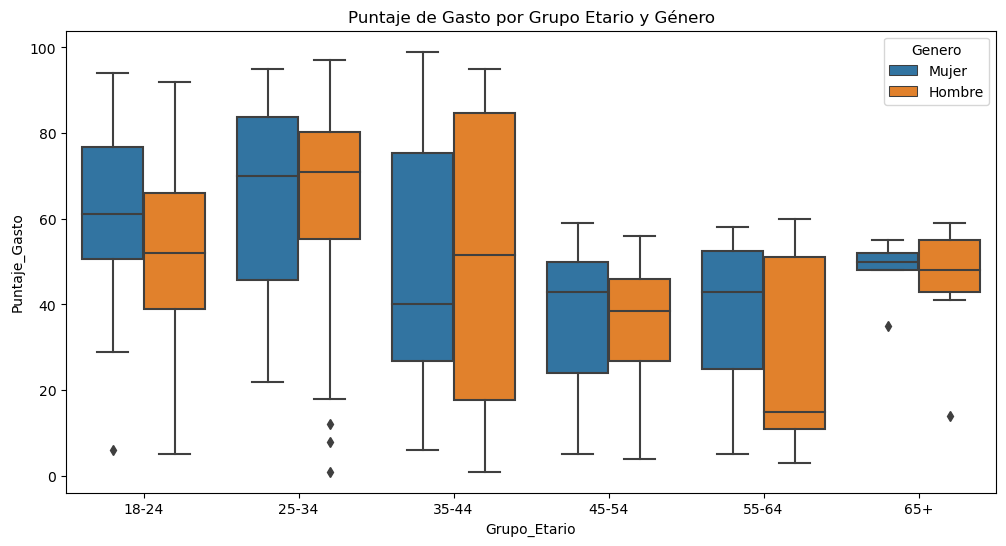

In [133]:
# Boxplot de ingresos por género y grupo etario
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Grupo_Etario', y='Ingreso', hue='Genero')
plt.title('Ingresos por Grupo Etario y Género')
plt.show()

# Boxplot de puntaje de gasto por género y grupo etario
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Grupo_Etario', y='Puntaje_Gasto', hue='Genero')
plt.title('Puntaje de Gasto por Grupo Etario y Género')
plt.show()

**Diagramas de dispersión**

Con el objetivo de visualizar relaciones entre las variables, se realizan diagramas de dispersión entre las distintas variables y el género. **No se observan relaciones entre las variables**. 

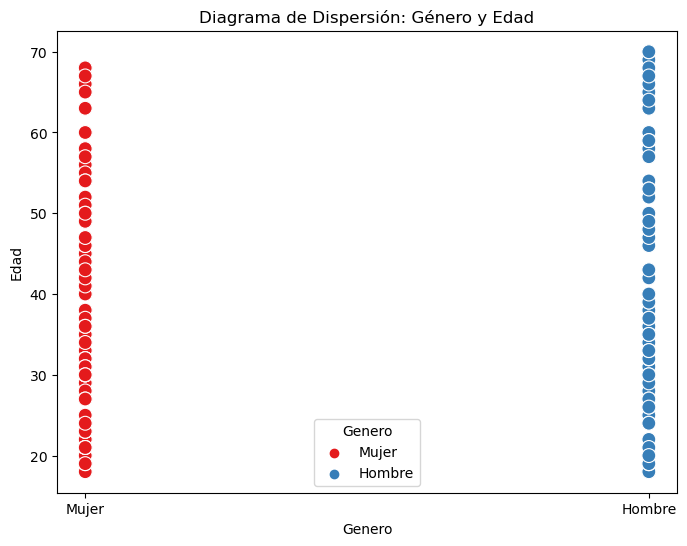

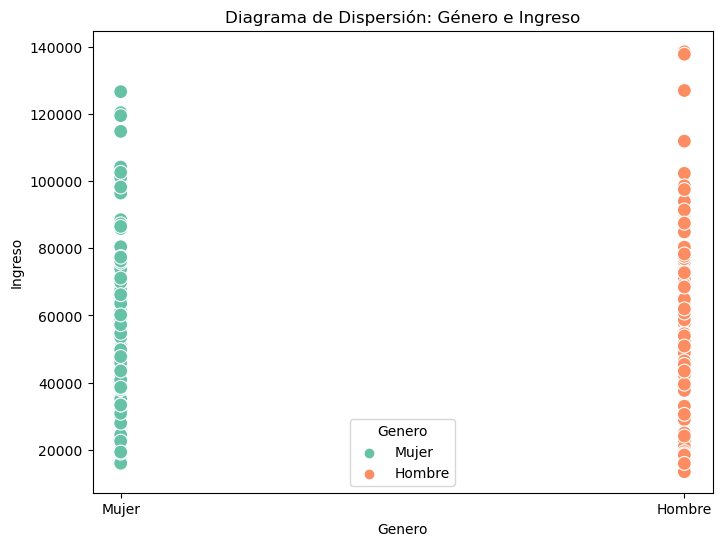

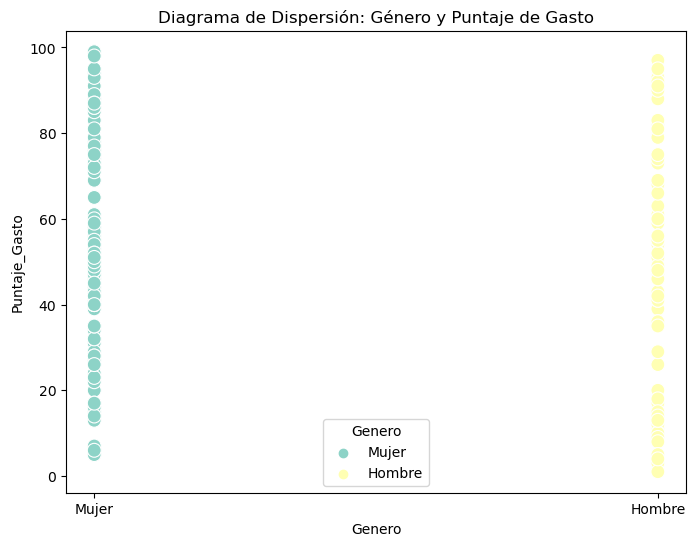

In [134]:
# Diagrama de dispersión: Género y Edad
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Genero', y='Edad', hue='Genero', palette='Set1', s=100)
plt.title('Diagrama de Dispersión: Género y Edad')
plt.show()

# Diagrama de dispersión: Género e Ingreso
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Genero', y='Ingreso', hue='Genero', palette='Set2', s=100)
plt.title('Diagrama de Dispersión: Género e Ingreso')
plt.show()

# Diagrama de dispersión: Género y Puntaje de Gasto
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Genero', y='Puntaje_Gasto', hue='Genero', palette='Set3', s=100)
plt.title('Diagrama de Dispersión: Género y Puntaje de Gasto')
plt.show()

Ahora se decide graficar Ingreso contra edad, puntaje de gasto contra ingreso y edad con puntaje de gasto

- Se observa una pequeña concentración en el centro entre el puntaje de gasto y el ingreso
- No se observan correlaciones positivas o negativas entre las variables

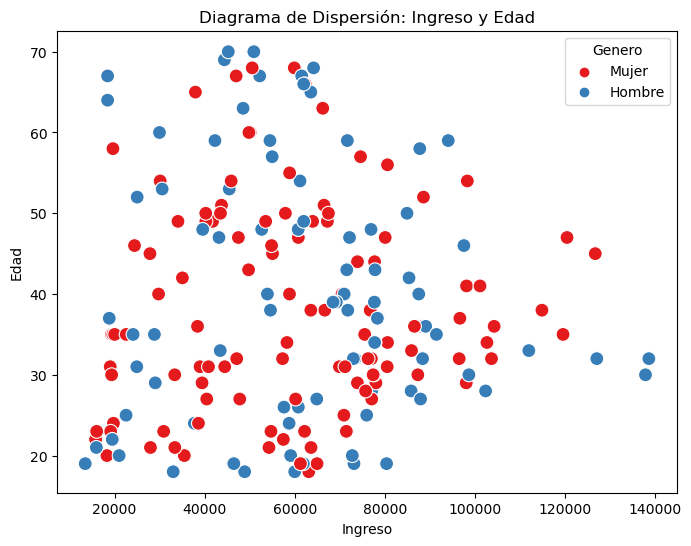

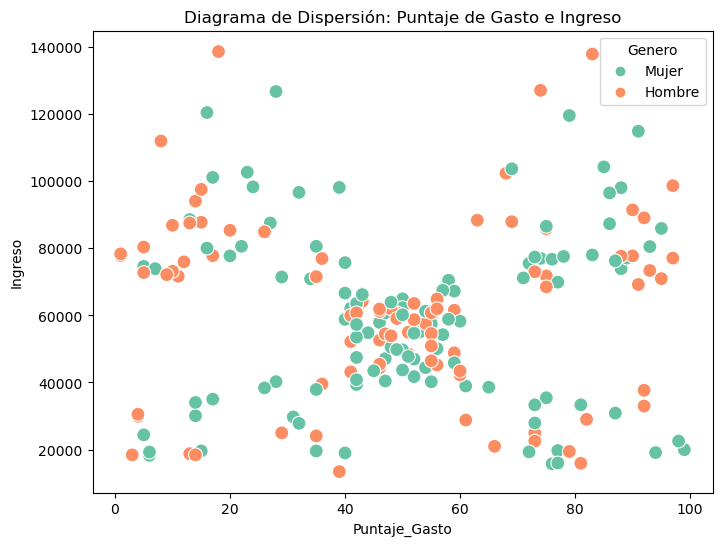

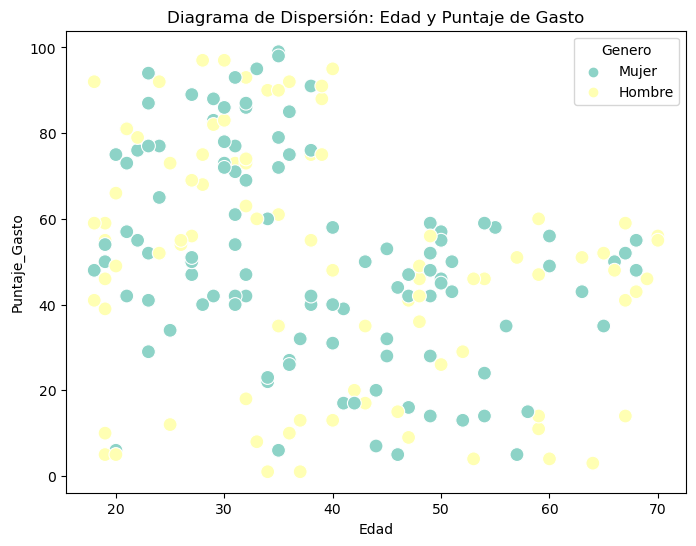

In [151]:
# Diagrama de dispersión: Ingreso y Edad
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Ingreso', y='Edad', hue='Genero', palette='Set1', s=100)
plt.title('Diagrama de Dispersión: Ingreso y Edad')
plt.show()

# Diagrama de dispersión: Puntaje de Gasto e Ingreso
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Puntaje_Gasto', y='Ingreso', hue='Genero', palette='Set2', s=100)
plt.title('Diagrama de Dispersión: Puntaje de Gasto e Ingreso')
plt.show()

# Diagrama de dispersión: Edad y Puntaje de Gasto
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='Edad', y='Puntaje_Gasto', hue='Genero', palette='Set3', s=100)
plt.title('Diagrama de Dispersión: Edad y Puntaje de Gasto')
plt.show()

A manera de resumen, se grafica un scatterplot separando los colores por género. 

- Se sigue sosteniendo que no existen correlaciones entre las variables
- Las variables cuantitativas tienen una distribución aproximadamente normal 

/Users/camilaleniss/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


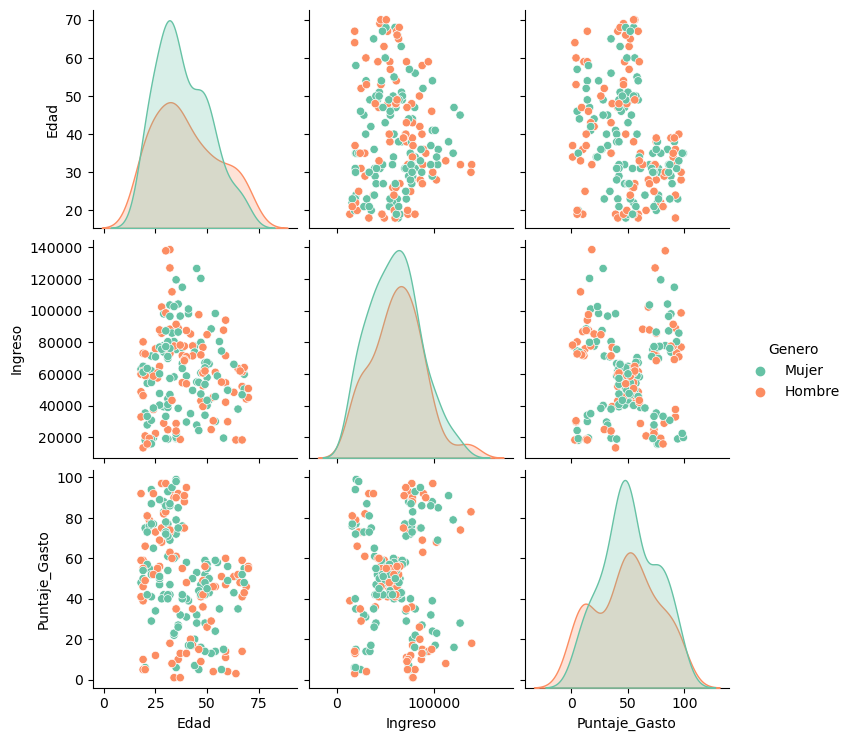

In [136]:
# Generar el pairplot entre todas las variables numéricas coloreado por Género
sns.pairplot(data, hue='Genero', diag_kind='kde', palette='Set2')

plt.show()

**¿Son estas diferencias estadísticamente significativas?**

Despues del análisis con gráficos y estadísticas descirptivas, no se encontraron diferencias grandes entre los grupos de hombre y mujeres. Se procede a realizar una prueba de t Student para comprobar si esto es estadísticamente significativo.

*¿Por qué la prueba t de Student?*
- Esta prueba se emplea para comparar las medias de dos grupos independientes. En este caso, se están comparando los ingresos promedio de mujeres y hombres.
- Se asume que los datos de ingresos de mujeres y hombres provienen de dos muestras independientes, es decir, que los individuos de un grupo no están relacionados con los individuos del otro grupo.
- Se sigue una distribución aproximadamente normal 

*Hipótesis*

- **Hipótesis nula (H0)**: No hay diferencia significativa entre el promedio de Ingreso entre hombres y mujeres
- **Hipótesis alternativa (H1):** Sí hay una diferencia significativa entre el promedio de Ingreso entre hombres y mujeres

In [137]:
from scipy import stats

# Prueba t para comparar el ingreso promedio entre hombres y mujeres
t_stat, p_value = stats.ttest_ind(data[data['Genero'] == 'Mujer']['Ingreso'],
                               data[data['Genero'] == 'Hombre']['Ingreso'])

if p_value < 0.05:
    # se rechaza H0
    print("Existe una diferencia significativa en el ingreso entre hombres y mujeres.")
else:
    # no se rechaza H0
    print("No se encontró una diferencia significativa en el ingreso entre hombres y mujeres.")

No se encontró una diferencia significativa en el ingreso entre hombres y mujeres.


En conclusión, no existe una diferencia estadísticamente significativa entre el ingreso de hombre y mujeres

*Hipótesis*

- **Hipótesis nula (H0)**: No hay diferencia significativa entre el promedio de Puntaje de gasto entre hombres y mujeres
- **Hipótesis alternativa (H1):** Sí hay una diferencia significativa entre el promedio de Puntaje de gasto entre hombres y mujeres

In [138]:
from scipy import stats

# Prueba t para comparar el ingreso promedio entre hombres y mujeres
t_stat, p_value = stats.ttest_ind(data[data['Genero'] == 'Mujer']['Puntaje_Gasto'],
                               data[data['Genero'] == 'Hombre']['Puntaje_Gasto'])

if p_value < 0.05:
    # se rechaza H0
    print("Existe una diferencia significativa en el puntaje de gasto entre hombres y mujeres.")
else:
    # no se rechaza H0
    print("No se encontró una diferencia significativa en el puntaje de gasto entre hombres y mujeres.")

No se encontró una diferencia significativa en el puntaje de gasto entre hombres y mujeres.


En conclusión, no existe una diferencia estadísticamente significativa entre el puntaje de gasto de hombre y mujeres

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

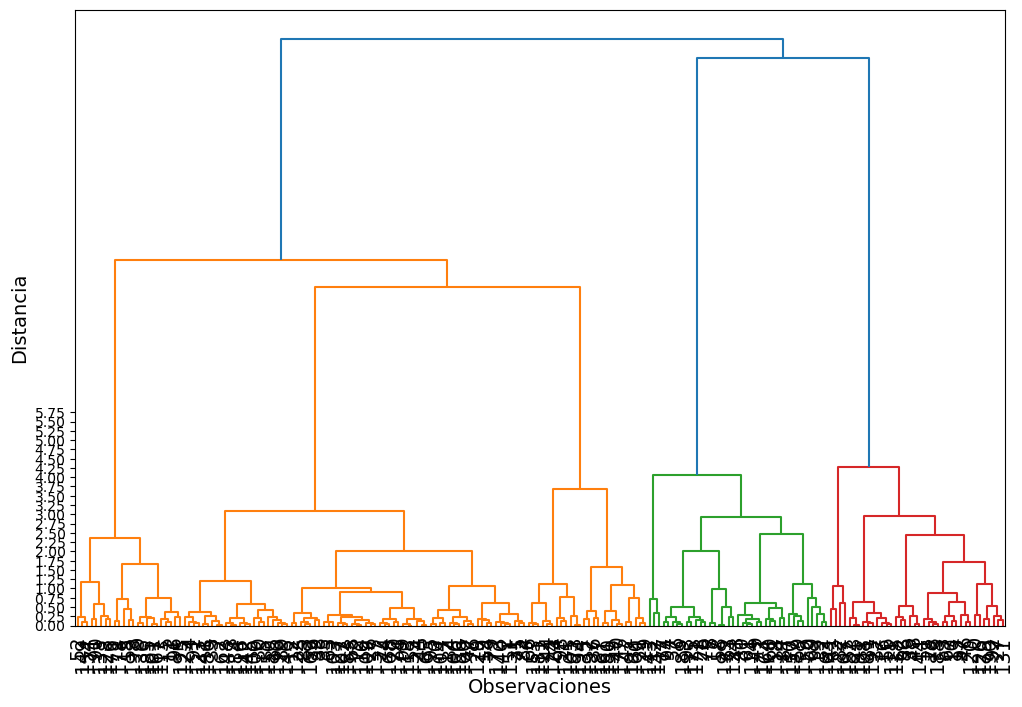

In [139]:
data_scaled = StandardScaler().fit_transform(data[['Ingreso', 'Puntaje_Gasto']])

# Calculando la matriz de distancias
Z = linkage(data_scaled, method='ward', metric='euclidean')

fig, ax = plt.subplots(figsize=(12, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_yticks(np.arange(0, 6, 0.25))
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

Se realizó la estandarización de Ingreso y Puntaje. **Esto se realiza para darle la unidad de medida no afecte el cálculo de la distancia.** Por ejemplo en este caso sabemos que puntaje va de 0-100, pero el ingreso tiene unidades más altas. Entonces para darle el mismo peso a ambas realizamos el escalamiento

Luego se calcula la matriz de distancias utilizando el método ward y la distancia euclidiana.

Por último se grafica el dendograma, donde se observa que dao que se tienen tantas combinaciones diferentes se pueden tener muchos subclusters.

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

In [140]:
# Fijar la distancia en 6 y obtener los clusters
max_dist = 6
clusters = fcluster(linked, max_dist, criterion='distance')

n_clusters = len(np.unique(clusters))

print("Número de clusters generados cuando la distancia es 6: ", n_clusters)

Número de clusters generados cuando la distancia es 6:  5


Tomando la matriz de distancias del punto anterior se fija la máxima distancia en 6 y se obtienen 5 cluster utilizando el método *fcluster* teniendo en cuenta la distancia. 

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

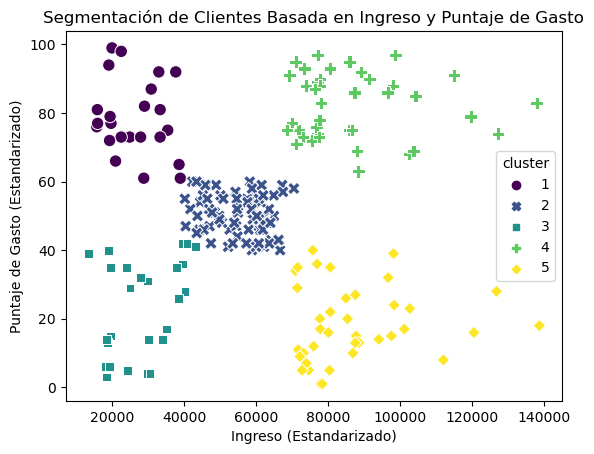

In [141]:
clusters = fcluster(Z, n_clusters, criterion='distance')

# Agregar la columna de clusters al DataFrame
data['cluster'] = clusters

sns.scatterplot(x='Ingreso', y='Puntaje_Gasto', hue='cluster', data=data,
                palette='viridis', style='cluster', s=80)
plt.title('Segmentación de Clientes Basada en Ingreso y Puntaje de Gasto')
plt.xlabel('Ingreso (Estandarizado)')
plt.ylabel('Puntaje de Gasto (Estandarizado)')
plt.show()

Utilizando la matriz de distancias del paso anterior, se grafican los clusters generados. Podemos observar 5 grupos bien definidos. Para lograr caracterizar los grupos, vamos a realizar estadísticas descriptivas para cada cluster.

In [142]:
for cluster_num in np.unique(clusters):
    print(f"Cluster {cluster_num}:")
    print(data[data['cluster'] == cluster_num].describe())

Cluster 1:
            Edad       Ingreso  Puntaje_Gasto  cluster
count  23.000000     23.000000      23.000000     23.0
mean   25.521739  26230.419565      78.565217      1.0
std     5.273170   7742.413865      10.953729      0.0
min    18.000000  15766.840000      61.000000      1.0
25%    21.500000  19590.810000      73.000000      1.0
50%    24.000000  24905.790000      77.000000      1.0
75%    30.000000  33157.710000      84.500000      1.0
max    35.000000  38950.660000      99.000000      1.0
Cluster 2:
            Edad       Ingreso  Puntaje_Gasto  cluster
count  74.000000     74.000000      74.000000     74.0
mean   43.594595  55451.258514      50.216216      2.0
std    16.787894   7847.567060       5.871385      0.0
min    18.000000  40218.680000      40.000000      2.0
25%    27.000000  48594.107500      46.000000      2.0
50%    47.500000  57359.505000      50.000000      2.0
75%    56.500000  61796.637500      55.000000      2.0
max    70.000000  70469.660000      60.0000

Podemos caracterizar los grupos de la siguiente manera:

**Cluster 1: Jovenes consumidores frecuentes, poco nivel de ingreso**
- Edad promedio 25 años
- Ingresos promedio 26.230
- Puntaje gasto promedio de 78

**Cluster 2: Adultos, consumidores habituales, nivel de ingreso promedio**
- Edad promedio 43 años
- Ingresos promedio 55.451
- Puntaje gasto promedio de 50

**Cluster 3: Adultos, consumidores poco frecuentes, bajo nivel de ingresos**
- Edad promedio 44 años
- Ingresos promedio 28.274
- Puntaje gasto promedio de 23

**Cluster 4: Adultos jovenes, consumidores frecuentes, nivel alto de ingresos**
- Edad promedio 32 años
- Ingresos promedio 86.537
- Puntaje gasto promedio de 82

**Cluster 5: Adultos, consumidores poco frecuentes, nivel alto de ingresos**
- Edad promedio 40 años
- Ingresos promedio 87.055
- Puntaje gasto promedio de 18

*Estrategia de marketing*

La estrategía de marketing podría enfocarse en el **cluster 4**, puesto que tenemos una buena capacidad adquisitiva y de por si ya son clientes fieles. Esto representaría un incremento en ventas sin tanto gasto de presupuesto de marketing. 

Una segunda estrategía podría concentrarse en los adultros de nivel alto de ingresos -**cluster 5**- pero que son consumidores poco frecuentes. Puesto que presenta una oportunidad de mercado para fidelizarlos.

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

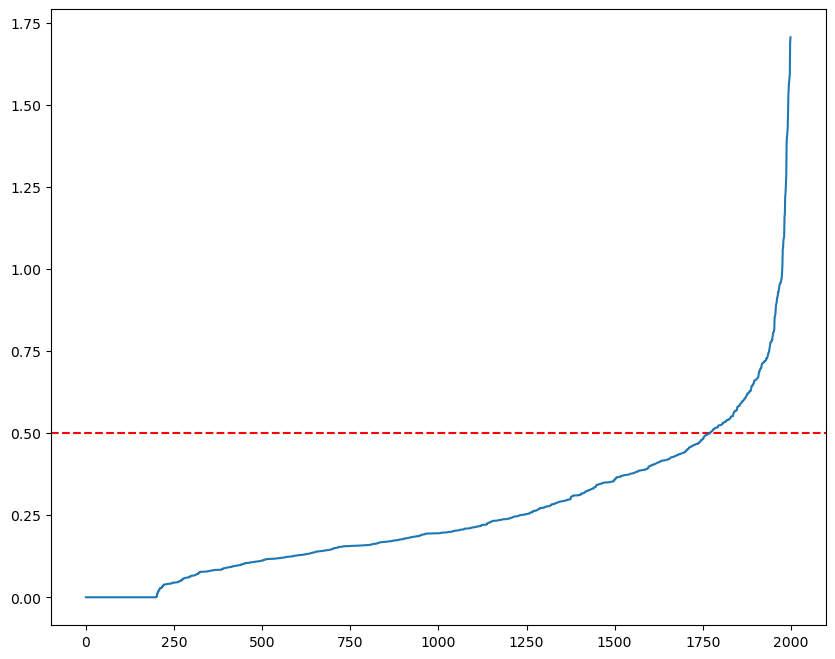

In [159]:
neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(data_scaled)

distancias, indices = nbrs.kneighbors(data_scaled)
distancias = np.sort(distancias.flatten())

fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 0.5, color = 'r', linestyle = '--')
plt.plot(distancias)

Utilizando el método de los vecinos más cercanos vemos que el punto óptimo de eps está en **0.493**. Esta será la distancia que se usará para la densidad. 

In [158]:
from kneed import KneeLocator

i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

opt_eps = distancias[knee.knee]
print(opt_eps)

0.4934968313866966


**Calibrando min_samples**

El parametro min_samples nos dice cuánto es el mínimo de muestras para formar un cluster, esto nos ayuda para formar clusters más densos, pero a la vez añade algo de ruido para números muy altos

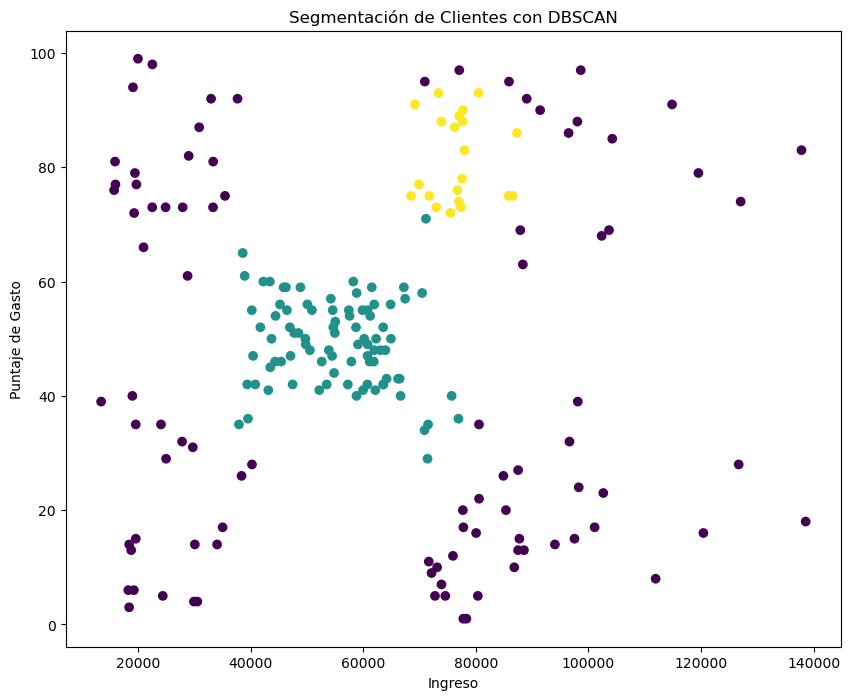

In [168]:
db = DBSCAN(eps=opt_eps, min_samples=20)
clusters = db.fit_predict(data_scaled)

# Agregando la columna de clusters al DataFrame
data['cluster'] = clusters

# Visualizando los clusters
plt.figure(figsize=(10, 8))
plt.scatter(X['Ingreso'], X['Puntaje_Gasto'], c=clusters, cmap='viridis')
plt.title('Segmentación de Clientes con DBSCAN')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.show()

Comenzando con un valor de 20 observamos 2 grupos definidos (verde y amarillo) y muchos valores de ruido. Se decide ir por un número más pequeño.

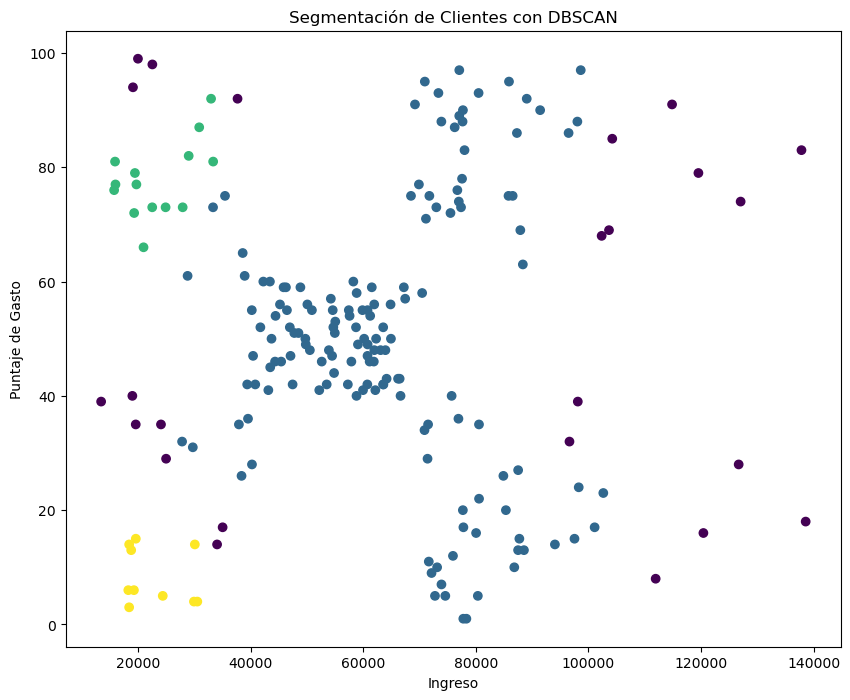

In [166]:
db = DBSCAN(eps=opt_eps, min_samples=10)
clusters = db.fit_predict(data_scaled)

# Agregando la columna de clusters al DataFrame
data['cluster'] = clusters

# Visualizando los clusters
plt.figure(figsize=(10, 8))
plt.scatter(X['Ingreso'], X['Puntaje_Gasto'], c=clusters, cmap='viridis')
plt.title('Segmentación de Clientes con DBSCAN')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.show()

Con un valor de 10 observamos más grupos formados, pero aún así parece que se forman grupos un poco alejados uno de otro.

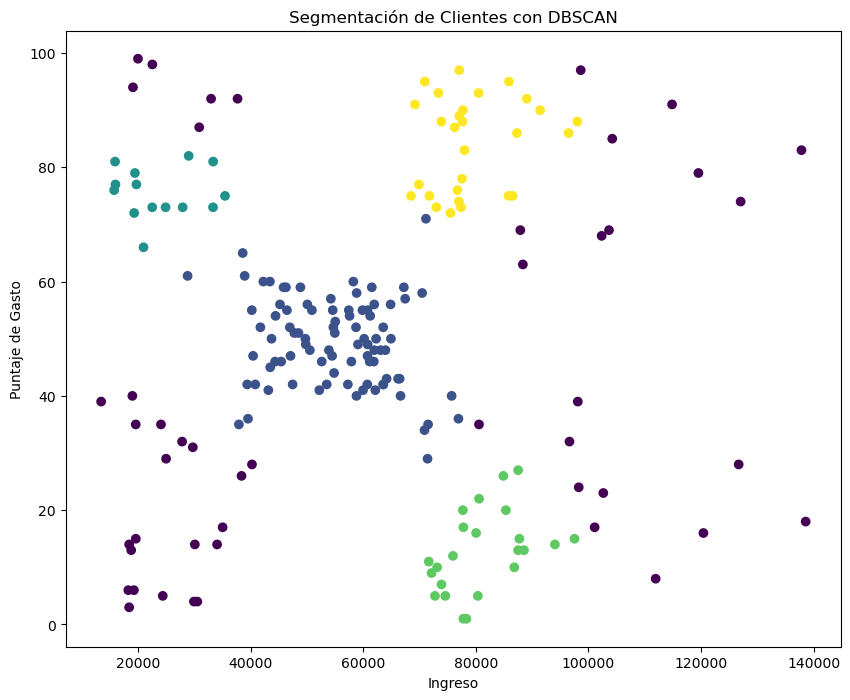

In [169]:
db = DBSCAN(eps=opt_eps, min_samples=15)
clusters = db.fit_predict(data_scaled)

# Agregando la columna de clusters al DataFrame
data['cluster'] = clusters

# Visualizando los clusters
plt.figure(figsize=(10, 8))
plt.scatter(X['Ingreso'], X['Puntaje_Gasto'], c=clusters, cmap='viridis')
plt.title('Segmentación de Clientes con DBSCAN')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.show()

Se encontró un punto medio, de 15, donde visualizamos 4 clusters bien definidos y algunos valores de ruido. Esto nos permite caracterizar un poco más compactamente a los grupos. 

In [170]:
for cluster_num in np.unique(clusters):
    print(f"Cluster {cluster_num}:")
    print(data[data['cluster'] == cluster_num].describe())

Cluster -1:
            Edad        Ingreso  Puntaje_Gasto  cluster  Genero_encoded  \
count  47.000000      47.000000      47.000000     47.0       47.000000   
mean   38.829787   60784.416809      42.340426     -1.0        0.617021   
std    11.911484   42715.386364      32.294350      0.0        0.491369   
min    18.000000   13458.020000       3.000000     -1.0        0.000000   
25%    32.000000   23322.030000      15.500000     -1.0        0.000000   
50%    36.000000   35034.660000      32.000000     -1.0        1.000000   
75%    46.500000  101725.510000      71.500000     -1.0        1.000000   
max    67.000000  138584.520000      99.000000     -1.0        1.000000   

       GrupoEtario_encoded  
count            47.000000  
mean              2.085106  
std               1.332369  
min               0.000000  
25%               1.000000  
50%               2.000000  
75%               3.000000  
max               6.000000  
Cluster 0:
            Edad       Ingreso  Puntaje_

Con los resultados obtenidos con DBSCAN podemos caracterizar los siguientes grupos: 

**Cluster -1: Ruido**

**Cluster 0: Adultos, consumidores habituales, nivel de ingreso promedio**
- Edad promedio 42 años
- Ingresos promedio 55.093
- Puntaje gasto promedio de 49.3

**Cluster 1: Jovenes, consumidores frecuentes, bajo nivel de ingresos**
- Edad promedio 24 años
- Ingresos promedio 23.837
- Puntaje gasto promedio de 75

**Cluster 2: Adultos, consumidores poco frecuentes, nivel alto de ingresos**
- Edad promedio 41 años
- Ingresos promedio 81.158
- Puntaje gasto promedio de 12

**Cluster 3: Adultos jovenes, consumidores frecuentes, nivel alto de ingresos**
- Edad promedio 33 años
- Ingresos promedio 79.265
- Puntaje gasto promedio de 84

*Estrategia de marketing*

En cuanto a estrategia parece que podemos seguir generando la misma: **adultos jovenes, consumidores frecuentes, nivel alto de ingresos** o abrir el mercado para los **adultos con alto nivel de ingresos pero que son consumidores poco frecuentes**.

Cabe resaltar que se reduce el ruido gracias a que no se necesita ubicar todas las personas en algún cluster. Pero se dejan de tener en cuenta casi 50 personas. Que podrían hacer parte de la estrategia de marketing. 

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

Con el objetivo de recordar el dataset que estamos utilizando, lo imprimimos y vemos que tenemos grupo etario ya creado como una variable categórica.

Ahora que necesitamos incorporar género y edad, vamos a utilizar `Grupo_Etario` y `Genero` 

In [147]:
data.head()

,Genero,Edad,Ingreso,Puntaje_Gasto,Grupo_Etario,cluster
Id_Cliente,,,,,,
1,Mujer,41,98115.05,39,35-44,0
2,Mujer,20,35458.14,75,18-24,1
3,Mujer,68,59872.08,55,65+,1
4,Hombre,63,48508.93,51,55-64,1
5,Mujer,31,44431.11,54,25-34,1


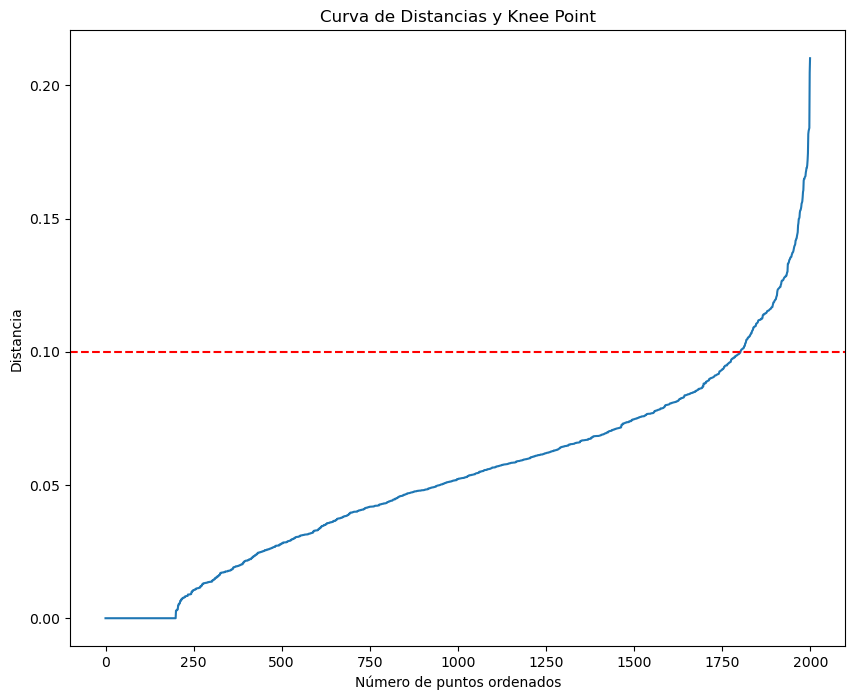

Valor óptimo de eps: 0.08809193968772888


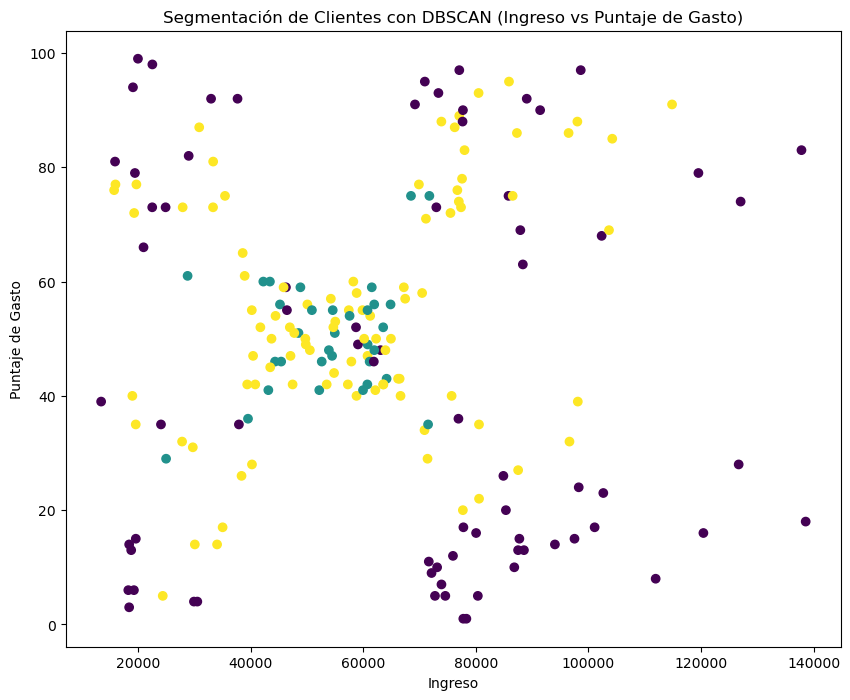

In [175]:
# Codificar variables categóricas
label_encoder = LabelEncoder()
data['Genero_encoded'] = label_encoder.fit_transform(data['Genero'])
data['GrupoEtario_encoded'] = label_encoder.fit_transform(data['Grupo_Etario'])

# Seleccionar las variables a utilizar escalandolas como en los. puntos anteriores
data_scaled = StandardScaler().fit_transform(data[['Ingreso', 'Puntaje_Gasto', 'Genero_encoded', 'GrupoEtario_encoded']])

X = data_scaled

# Calculamos la distancia de Gower
dist_matrix = gower.gower_matrix(X)

# Buscamos el valor óptimo de eps usando NearestNeighbors como en el punto anterior
neigh = NearestNeighbors(n_neighbors=10, metric='precomputed')
nbrs = neigh.fit(dist_matrix)

distancias, indices = nbrs.kneighbors(dist_matrix)
distancias = np.sort(distancias.flatten())

# Visualizamos el gráfico de distancias y el knee point
fig = plt.figure(figsize=(10, 8))
plt.plot(distancias)
plt.axhline(y=0.1, color='r', linestyle='--')
plt.title('Curva de Distancias y Knee Point')
plt.xlabel('Número de puntos ordenados')
plt.ylabel('Distancia')
plt.show()

# Determinamos el knee point para encontrar el valor óptimo de eps
i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')
opt_eps = distancias[knee.knee]
print(f"Valor óptimo de eps: {opt_eps}")

# Aplicamos DBSCAN utilizando la distancia de Gower
db = DBSCAN(eps=opt_eps, min_samples=15, metric='precomputed')
clusters = db.fit_predict(dist_matrix)

# Añadimos los clusters al DataFrame
data['cluster'] = clusters

# Visualizamos los clusters usando dos variables, como ejemplo
plt.figure(figsize=(10, 8))
plt.scatter(data['Ingreso'], data['Puntaje_Gasto'], c=clusters, cmap='viridis')
plt.title('Segmentación de Clientes con DBSCAN (Ingreso vs Puntaje de Gasto)')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.show()


**Procedimiento**

- Codificación de variables categoricas
- Escalamiento de variables
- Cálculo de distancia de Gower
- Encontrar el eps optimo con el knee point. En este caso fue de 0.08 
- Correr el algoritmo DBSCAN con min_samples de 15 como en el punto anterior para tener el mismo criterio
- Graficamos Ingreso vs Puntaje para tener un acercamiento inicial a los clusters 

Ahora con el objetivo de perder poca información dada por las variables añadidas, realizamos PCA para reducir la dimensionalidad a dos dimensiones y graficar los cluster:

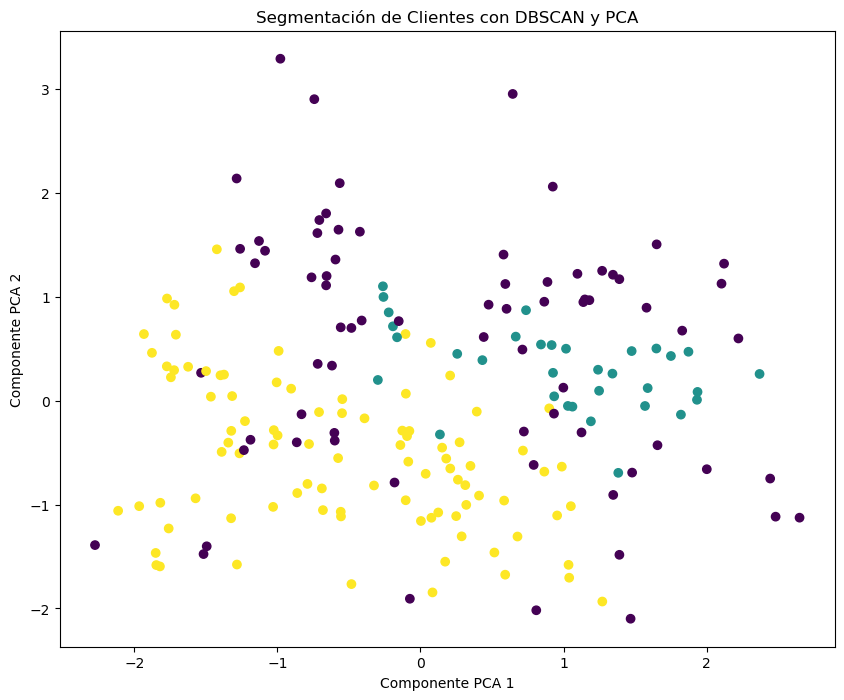

In [176]:
# Reducción de dimensionalidad con PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # X es el DataFrame con las variables originales

# Visualización de los clusters en 2D utilizando PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Segmentación de Clientes con DBSCAN y PCA')
plt.xlabel('Componente PCA 1')
plt.ylabel('Componente PCA 2')
plt.show()

En este caso vemos que tenemos 2 cluster y ruido. Debido al reto de caracterizar los cluster se procede a sacar estadísticas descriptivas.

A simple vista parece que tenemos dos grupos más inclinados hacia nivel de ingresos y puntaje que teniendo en cuenta la edad o el género.

In [177]:
for cluster_num in np.unique(clusters):
    print(f"Cluster {cluster_num}:")
    print(data[data['cluster'] == cluster_num].describe())

Cluster -1:
            Edad        Ingreso  Puntaje_Gasto  cluster  Genero_encoded  \
count  73.000000      73.000000      73.000000     73.0       73.000000   
mean   36.164384   67037.779178      44.164384     -1.0        0.246575   
std    13.259183   33827.363541      34.463755      0.0        0.434000   
min    18.000000   13458.020000       1.000000     -1.0        0.000000   
25%    25.000000   30542.080000      13.000000     -1.0        0.000000   
50%    35.000000   73899.970000      35.000000     -1.0        0.000000   
75%    45.000000   87906.830000      79.000000     -1.0        0.000000   
max    67.000000  138584.520000      99.000000     -1.0        1.000000   

       GrupoEtario_encoded  
count            73.000000  
mean              1.849315  
std               1.515395  
min               0.000000  
25%               1.000000  
50%               2.000000  
75%               3.000000  
max               6.000000  
Cluster 0:
            Edad       Ingreso  Puntaje_

**Cluster -1: Ruido**
- Edad promedio 36 años
- Ingresos promedio 67.037
- Puntaje Gasto: 44

**Cluster 0: Adultos, consumidores habituales, nivel de ingreso promedio**
- Edad promedio 48 años
- Ingresos promedio 53.909
- Puntaje gasto promedio de 50

**Cluster 1: Adultos, consumidores un poco más habituales, nivel de ingreso promedio alto**
- Edad promedio 37 años
- Ingresos promedio 58.001
- Puntaje gasto promedio de 54

No parece que incorporar las variables de Edad y Género haya ayudado a la focalización. Se encuentran dos grupos muy parecidos que no exhiben carácterísticas muy diferentes para lograr realizar una estrategia de marketing 

### Conclusiones

- Se sugiere seguir con el clustering jerarquico para la caracterización de la estrategia de marketing, puesto que no deja personas por fuera de los grupos y permite encontrar oportunidades para todos. 
- Utilizando DBSCAN se puede caracterizar un grupo que representa ruido para la estrategia
- Añadir variables como la edad y el género no ayuda a caracterizar los diferentes grupos para generar una estrategia de marketing